In [1]:
try:
    import tinygp
except ImportError:
    !pip install -q tinygp

/opt/homebrew/Caskroom/miniforge/base/envs/tinygp/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Custom kernels: Radial velocity example

To demonstrate the flexibility of the `tinygp` kernel building interface, we will build a custom kernel that is commonly used when studying radial velocity observations of exoplanet-hosting stars, as described by [Rajpaul et al. (2015)](https://arxiv.org/abs/1506.07304).
Take a look at that paper for more details about the math, but the tl;dr is that we want to model a set parallel, but qualitatively different, time series, using a latent Gaussian process.
The interesting part of this model is that Rajpaul et al. model the observations as arbitrary linear combinations of the process and its first time derivative, and they work through the derivation of the resulting kernel function.

In this tutorial, we will implement this kernel using `tinygp`—something that is significantly more annoying to do with other Gaussian process frameworks (trust me, I've tried!)—and demonstrate a few key features along the way.
Besides describing the interface for implementing new kernels and kernel transforms, we also show how `tinygp` can support arbitrary [JAX pytrees](https://jax.readthedocs.io/en/latest/pytrees.html) as input.

## The kernel

The kernel matrix described by [Rajpaul et al. (2015)](https://arxiv.org/abs/1506.07304) is a block matrix where each element is a linear combination of the latent kernel and its first and second derivatives, where the relevant coefficients depend on the "class" of each pair of observations.
This means that our input data needs to include, at each observation, the time `t` (our input coordinate in this case) and an integer class label `label`.
As discussed below, we will structure our data in such a way that we can treat each input as being a tuple `(t, label)`.

Now, let's implement this kernel in a way that `tinygp` understands.
When doing this, you will subclass {class}`tinygp.kernels.Kernel` and implement the {func}`tinygp.kernels.Kernel.evaluate` method.
One very important thing to note here is that `evaluate` will always be called via `vmap`, so you should write your `evaluate` method to operate on a **single pair of inputs** and let `vmap` handle the broadcasting sematics for you.
In this case, we will unpack our inputs `t, label = X` and treat `t` and `label` as scalars.

Here's our implementation:

In [2]:
import tinygp

import jax
import jax.numpy as jnp
from jax.config import config

config.update("jax_enable_x64", True)


class DerivativeKernel(tinygp.kernels.Kernel):
    """A custom kernel based on Rajpaul et al. (2015)

    Args:
        kernel: The kernel function describing the latent process. This can be any other
            ``tinygp`` kernel.
        coeff_prim: The primal coefficients for each class. This can be thought of as how
            much the latent process itself projects into the observations for that class.
            This should be an array with an entry for each class of observation.
        coeff_deriv: The derivative coefficients for each class. This should have the same
            shape as ``coeff_prim``.
    """

    def __init__(self, kernel, coeff_prim, coeff_deriv):
        self.kernel = kernel
        self.coeff_prim, self.coeff_deriv = jnp.broadcast_arrays(
            jnp.asarray(coeff_prim), jnp.asarray(coeff_deriv)
        )

    def evaluate(self, X1, X2):
        t1, label1 = X1
        t2, label2 = X2

        # Differentiate the kernel function: the first derivative wrt x1
        Kp = jax.grad(self.kernel.evaluate, argnums=0)

        # ... and the second derivative
        Kpp = jax.grad(Kp, argnums=1)

        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel.evaluate(t1, t2)
        d2K_dx1dx2 = Kpp(t1, t2)

        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(self.kernel.evaluate, argnums=1)(t1, t2)
        dK_dx1 = Kp(t1, t2)

        # Extract the coefficients
        a1 = self.coeff_prim[label1]
        a2 = self.coeff_prim[label2]
        b1 = self.coeff_deriv[label1]
        b2 = self.coeff_deriv[label2]

        # Construct the matrix element
        return (
            a1 * a2 * K
            + a1 * b2 * dK_dx2
            + b1 * a2 * dK_dx1
            + b1 * b2 * d2K_dx1dx2
        )

Now that we have this definition, we can plot what the kernel functions look like for different latent processes.
Don't worry too much about the syntax here, but we're plotting two classes of observations where the first class is just a direct observation of the latent process and the second observes the time derivative.

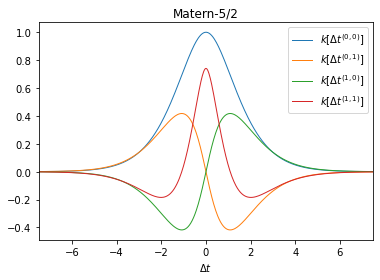

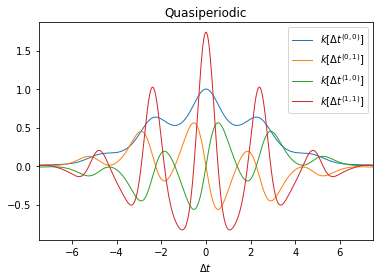

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def plot_kernel(latent_kernel):
    kernel = DerivativeKernel(latent_kernel, [1.0, 0.0], [0.0, 1.0])

    N = 500
    dt = np.linspace(-7.5, 7.5, N)

    k00 = kernel(
        (jnp.zeros((1)), jnp.zeros((1), dtype=int)),
        (dt, np.zeros(N, dtype=int)),
    )[0]
    k11 = kernel(
        (jnp.zeros((1)), jnp.ones((1), dtype=int)), (dt, np.ones(N, dtype=int))
    )[0]
    k01 = kernel(
        (jnp.zeros((1)), jnp.zeros((1), dtype=int)),
        (dt, np.ones(N, dtype=int)),
    )[0]
    k10 = kernel(
        (jnp.zeros((1)), jnp.ones((1), dtype=int)),
        (dt, np.zeros(N, dtype=int)),
    )[0]

    plt.figure()
    plt.plot(dt, k00, label="$k[\Delta t^{(0,0)}]$", lw=1)
    plt.plot(dt, k01, label="$k[\Delta t^{(0,1)}]$", lw=1)
    plt.plot(dt, k10, label="$k[\Delta t^{(1,0)}]$", lw=1)
    plt.plot(dt, k11, label="$k[\Delta t^{(1,1)}]$", lw=1)
    plt.legend()
    plt.xlabel(r"$\Delta t$")
    plt.xlim(dt.min(), dt.max())


plot_kernel(tinygp.kernels.Matern52(scale=1.5))
plt.title("Matern-5/2")

plot_kernel(
    tinygp.kernels.ExpSquared(scale=2.5)
    * tinygp.kernels.ExpSineSquared(period=2.5, gamma=0.5)
)
_ = plt.title("Quasiperiodic")

Given this custom kernel, let's simulate some data.

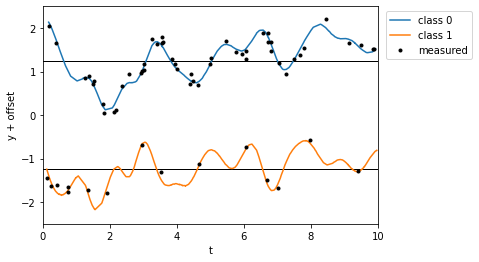

In [39]:
latent_kernel = tinygp.kernels.ExpSquared(scale=1.5) * tinygp.kernels.ExpSineSquared(period=2.5, gamma=0.5)
kernel = DerivativeKernel(latent_kernel, [1.0, 0.5], [-0.1, 0.3])

random = np.random.default_rng(5678)
t1 = np.sort(random.uniform(0, 10, 200))
label1 = np.zeros_like(t1, dtype=int)
t2 = np.sort(random.uniform(0, 10, 300))
label2 = np.ones_like(t2, dtype=int)
X = (np.append(t1, t2), np.append(label1, label2))

gp = tinygp.GaussianProcess(kernel, X, diag=1e-5)
y = gp.sample(jax.random.PRNGKey(1234))

subset = np.append(random.integers(len(t1), size=50), len(t1) + random.integers(len(t2), size=15))
X_obs = (X[0][subset], X[1][subset])
y_obs = y[subset] + 0.1 * random.normal(size=len(subset))

offset = 2.5

plt.axhline(0.5 * offset, color="k", lw=1)
plt.axhline(-0.5 * offset, color="k", lw=1)

plt.plot(t1, y[:len(t1)] + 0.5 * offset, label="class 0")
plt.plot(t2, y[len(t1):] - 0.5 * offset, label="class 1")

plt.plot(X_obs[0], y_obs + offset * (0.5 - X_obs[1]), ".k", label="measured")

plt.xlim(0, 10)
plt.ylim(-offset, offset)
plt.xlabel("t")
plt.ylabel("y + offset")
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

In [40]:
def build_gp(params):
    latent_kernel = tinygp.kernels.ExpSquared(scale=jnp.exp(params[0])) * tinygp.kernels.ExpSineSquared(period=jnp.exp(params[1]), gamma=params[2])
    kernel = DerivativeKernel(latent_kernel, params[3:5], params[5:7])
    return tinygp.GaussianProcess(kernel, X_obs, diag=jnp.exp(params[7]))

@jax.jit
@jax.value_and_grad
def loss(params):
    gp = build_gp(params)
    return -gp.condition(y_obs)

In [41]:
from scipy.optimize import minimize

init = jnp.array([np.log(1.5), np.log(2.5), 0.5, 1.0, 0.5, -0.1, 0.3, np.log(0.1)])
print(f"Initial negative log likelihood: {loss(init)[0]}")
soln = minimize(loss, init, jac=True)
print(f"Final negative log likelihood: {soln.fun}")

Initial negative log likelihood: 18.547339999953152
Final negative log likelihood: -20.01400374853378


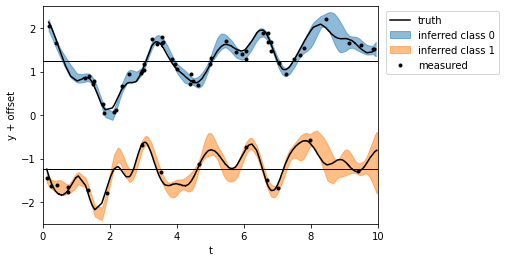

In [45]:
gp = build_gp(soln.x)
mu, var = gp.predict(y_obs, X, return_var=True)

plt.axhline(0.5 * offset, color="k", lw=1)
plt.axhline(-0.5 * offset, color="k", lw=1)

plt.plot(t1, y[:len(t1)] + 0.5 * offset, "k", label="truth")
plt.plot(t2, y[len(t1):] - 0.5 * offset, "k")

for c in [0, 1]:
    delta = offset * (0.5 - c)
    m = X[1] == c
    # plt.plot(X[0][m], delta + mu[m], color=f"C{c}")
    plt.fill_between(
        X[0][m], delta + mu[m] + 2 * np.sqrt(var[m]), delta + mu[m] - 2 * np.sqrt(var[m]), color=f"C{c}", alpha=0.5,
        label=f"inferred class {c}"
    )

plt.plot(X_obs[0], y_obs + offset * (0.5 - X_obs[1]), ".k", label="measured")

plt.xlim(0, 10)
plt.ylim(-offset, offset)
plt.xlabel("t")
plt.ylabel("y + offset")
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")